# cphonon function
### Authors
Written in matlab by Anders Blom, *1999*
Improved by Björn Samuelsson, *2000*
Converted to python Andris Potrebko *2019*

# Here I am just playing around with widgets

In [6]:
%matplotlib inline
%matplotlib notebook

from scipy.sparse import diags
import numpy as np
from scipy.linalg import eig
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive

from IPython.display import display #Java - not there anymore for running cells from widgits

# For plots being displaied right under the shell
#import scipy as sp

# pretty print all cell's output and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

###Plotly Not sure if works
# from plotly.offline import init_notebook_mode, iplot
# from plotly.graph_objs import *

In [7]:
# %matplotlib notebook
# %matplotlib notebook
# from matplotlib import pyplot as plt
# x = np.linspace(0, 2 * np.pi)
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# line, = ax.plot(x, np.sin(x))

# def update(w = 1.0):
#     line.set_ydata(np.sin(w * x))
#     fig.canvas.draw_idle()

# interact(update);

# Real code starts here

For fun witg widgets:

In [8]:
# x=5
# slider = widgets.IntSlider()
# slider.value = x
# def on_change(v):
#    global x
#    T = v['new'] 
# slider.observe(on_change, names='value')
# display(slider)

### Some initial values

In [9]:
N = 10
M1 = 0.5
M2 = 1
C = 1
imp_enabled = 0
Nimp = 5
Mimp = 5
bc = 0

Create force matrix, with 2 on the diagonal and -1 on each side


In [10]:
def CreateForceMatrix(N):
    tmp1 = [-1]*(N-1)
    tmp2 = [2]*N
    diagonals = [tmp1, tmp2, tmp1]  # the diagonals of the force matrix
    A = diags(diagonals, [-1, 0, 1]).todense()
    return(A)


A = CreateForceMatrix(N)

Update the force matrix considering all boundary conditions

In [11]:
def ForceMatrixBoundaryCond(A, bc, N):
    if bc == 2:  # open ends
        A[0, 0] = 1
        A[N-1, N-1] = 1
    elif bc == 1:  # fixed ends
        A[0, 0] = - 2  # this will generate negative eigenvalues, to be removed below
        A[N-1, N-1] = - 2
        A[1, 0] = 0
        A[0, 1] = 0
        A[N - 2, N-1] = 0
        A[N-1, N - 2] = 0
    else:  # periodic boundary cond.
        A[0, N-1] = - 1
        A[N-1, 0] = - 1
    return(A)


A = ForceMatrixBoundaryCond(A, bc, N)

Create mass matrix, take care of impurities

In [12]:
def CreateMassMatrix(N, M1, M2, Nimp, Mimp, imp_enabled):
    Nimp = Nimp-1  # Python counts from 0
    B = np.zeros(shape=(N, N))  # diags([1]*N,0).todense()
    for i in range(N):
        if i % 2 == 0:  # if even
            B[i, i] = 1 / M1
        else:
            B[i, i] = 1 / M2

    if imp_enabled:
        B[Nimp, Nimp] = 1 / Mimp
    return(B)


B = CreateMassMatrix(N, M1, M2, Nimp, Mimp, imp_enabled)

### Solve the eigenvalue equation
We get *omega* - eigenfrequecies and V - the vector of all displacements *u*

Set number of modes for fixed b.c. this number will be reduced by 2 as we remove negative eigenvalues (Two of the atoms don't move)

In [13]:
def EigenEq(A, B, C, bc, N):
    A1 = np.dot(C*B, A)
    D, V = eig(A1)
    D = np.real(D)
    Nmodes = N
    # Find negative eigenvalues and remove corresponding eigenvectors/-values for fixed b.c
    if bc == 1:
        for k in range(2):
            neg = -1
            for i in range(Nmodes):
                if ((D[i] < -1e-06) & (neg == -1)):
                    neg = i
            D = np.concatenate([D[:(neg)], D[(neg+1):]])
            V = np.concatenate([V[:, :(neg)], V[:, (neg+1):]], axis=1)
            Nmodes = Nmodes - 1

    # Abs because D can be slightly negative ex. -6.10622664e-16
    omega = np.sqrt(np.abs(D))
    # sort the eigenvalues and eigenmodes according to the eigenvalues
    ind = np.argsort(omega)
    omega = np.sort(omega)
    V = V[:, ind]

    return(omega, V, Nmodes)


omega, V, Nmodes = EigenEq(A, B, C, bc, N)

In [14]:
# take some care if eigenvalue is first or last in vector
# =============================================================================
#             if neg == 1:
#                 D=D[1:]
#                 V=V[1:,:]
#             else:
#                 if neg == Nmodes:
#                     D=D[:(Nmodes - 1)]
#                     V=V[:(Nmodes-1),:]
#                 else:
#                     if neg != 0:
# =============================================================================

### Discrete fourier transform
We use Fast fourier transform algorithm (*fft* function) to implement the discrete fourier transform.
* For the case of *fixed ends* boundary conditions the smallest wave possible can be a wave with the wavelength *2*\(N-1)* - the wave can be antisymetric with the wave outside. This is why we are looking for *2*\(N-1)* wave number, but taking at the end only the first *Nmodes* possible ones.
* For the case of *open ends* - the real periodicity is *2*\N*
* For periodic boundary conditions, the periodicity is *N* but we cut *np.floor(N/2)* <- **?????** 
Ech frequency except zero is doubly degenerate with +K and -K solutions (moving in opposite directions)

Don't get imag of coefficients //Andris **Need to check the open ends if it is symetric**


In [15]:
def FourierTransform(bc, V, N, Nmodes):
    if bc == 2:  # open ended
        wavemax = Nmodes
        Kk = np.fft.fft(V, 2*N, axis=0)
        Kk = Kk[:int(wavemax) + 1, :Nmodes]
        Ksq = np.real(Kk*np.conj(Kk))
        Karg = np.angle(Kk)
    elif bc == 1:  # fixed imaginary part turns out to work better. Still don't get why
        wavemax = Nmodes
        Kk = np.imag(np.fft.fft(V, 2*(N - 1), axis=0))
        Kk = Kk[:wavemax + 1, :Nmodes]
        Ksq = Kk*Kk
        Karg = 'NA'
        # Karg=Na
    else:  # periodic
        wavemax = np.floor(N / 2)
        Kk = np.fft.fft(V, N, axis=0)
        Kk = Kk[:int(wavemax) + 1, :Nmodes]
        Ksq = np.real(Kk*np.conj(Kk))  # can be a bit negative
        Karg = np.angle(Kk)

    Ka = np.argmax(Ksq, axis=0)
    # mx=np.max(Ksq,axis=0)#this one we don't need
    return(Ka, Karg)  # maybe Kk,


Ka, Karg = FourierTransform(bc, V, N, Nmodes)

In [16]:
# Ksq1=np.imag(Kk)*np.imag(Kk)
# Ksq2=np.real(Kk*np.conj(Kk))

# plt.plot(Ksq1[:,0])
# plt.plot(Ksq2[:,0])

# #plt.plot(np.imag(Ksq1[:,1]))
#plt.plot(np.imag(Ksq2[:,1]))
#plt.plot(np.real(Ksq1[:,1]))
#plt.plot(np.real(Ksq2[:,1]))

In [39]:
# %%capture 
# fig, ax = plt.subplots();
# #wavemax=np.floor(N / 2)
# Ksq=Kk*Kk
# ax.plot(np.real(Ksq[:,1]))
# ax.plot(np.real(Ksq[:,2]))
# #ax.plot(np.real(V[:,1]))
# #ax.plot(np.real(V[:,2]))
# fig

In [40]:
# plt.plot(Ksq[:,])

In [41]:
V

matrix([[-2.76161633e-04, -3.28982437e+00, -3.32165208e-16,
         -1.21656003e-01, -1.55915606e+00, -3.28407550e+00,
         -2.62008914e-16, -2.76504775e+00, -8.35646665e-18,
         -1.86647227e+00],
        [-2.76161633e-04, -2.87630335e+00, -2.08975671e+00,
         -2.86374373e+00, -6.89555967e-01,  2.69401766e-01,
         -8.29133380e-01,  1.03496569e+00,  7.51946592e-01,
          9.33236136e-01],
        [-2.76161633e-04, -1.01661164e+00, -3.12880890e+00,
         -8.18027166e-01,  1.33289136e+00,  2.65687289e+00,
          1.93033115e+00, -8.54446744e-01, -2.62971668e+00,
         -1.86647227e+00],
        [-2.76161633e-04,  1.09865012e+00, -3.38129738e+00,
          1.91150652e+00,  2.24112883e+00, -7.05302980e-01,
          5.12432610e-01, -3.95321718e-01,  1.21667514e+00,
          9.33236136e-01],
        [-2.76161633e-04,  2.66152382e+00, -1.93371025e+00,
          1.44525176e+00, -5.97507454e-01, -1.01483514e+00,
         -3.12334141e+00,  2.23697062e+00, -1.625254

###Bunch of boring but important manipulations with the results.
* For periodic boundary conditions we have doubly degenerate levels. If we have degenerate levels: give that one with the smallest phase angle a plus sign and the other a minus sign.
* *Ka* values from the fft are only positive. Here we correct the signs filling up the dispersion plot
* Give the corect amplitude for *Ka*

In [20]:
# set Ka to the index of the biggest squared coefficient
def CorrectOmega(Ka, Karg, Nmodes, V, omega, bc, M1, M2, N):
    if not(Nmodes):  # if Nmodes = 0 (case when bc=1 and N=2) gives an error
        maxi = 0
    else:
        maxi = np.argmax(Ka)

    if bc == 0:
        for j in range(Nmodes-1):
            if np.abs(omega[j] - omega[j + 1]) < 1e-06:  # if both omegas "almost"" equal
                v1 = Karg[Ka[j], j]
                v2 = Karg[Ka[j+1], j + 1]
                diff = v2 - v1
                if diff < - np.pi:
                    diff = diff + 2*np.pi
                elif diff > np.pi:
                    diff = diff - 2*np.pi
                # those where maxi+1 is even Ka will be -Ka, see below in this sec.
                if diff > 0 or not((maxi+1) % 2 < 0):
                    V[:, j] = - V[:, j]
                if np.abs(np.abs(diff) - np.pi / 2) > 1e-06:
                    # make them both orthonormal (supposes normated vectors)
                    V[:, j + 1] = V[:, j + 1] - V[:, j] * \
                        np.dot(V[:, j + 1], V[:, j])
                    V[:, j + 1] = V[:, j + 1] / \
                        np.sqrt(np.dot(V[:, j + 1], V[:, j + 1]))

    # Change sigh of every second Ka, depending on which is the maximum Ka
    Ka[(maxi) % 2::2] = -Ka[(maxi) % 2::2]

    # set correct magnitude of Ka
    if bc == 1:
        Ka = Ka*np.pi / (N - 1)
    else:
        Ka = Ka*2*np.pi / N

    # The high Ka values () belong to
    if M1 != M2:
        Ka = Ka*2

        for i in range(Nmodes):
            if np.abs(Ka[i]) > np.pi:
                Ka[i] = np.sign(Ka[i])*(np.abs(Ka[i]) - 2*np.pi)

    # correct sign if the last Ka is on the right boundary to the left side (we define our interval of Ka: [-pi/a, pi/a) )
    for i in range(Nmodes):
        if np.abs(Ka[i] - np.pi) < 1e-06:
            Ka[i] = - Ka[i]
    return(V, omega, Ka)


V, omega, Ka = CorrectOmega(Ka, Karg, Nmodes, V, omega, bc, M1, M2, N)

In [21]:
# Vdiff=V[:(N-1),:]-V[1:N,:]
# if bc==0:
#     Vdiff=np.vstack((Vdiff[:(N-1),:],V[(N-1),:] - V[0,:]))

# Vdiff=V[:(N-1),:]-V[1:N,:]
# if bc==0:
#     Vdiff = np.vstack((Vdiff[:(N-1),:],V[(N-1),:] - V[0,:]))
# Vdiff=np.diag(np.dot(np.transpose(Vdiff),Vdiff)).copy()

# if Nmodes!=0:   #Otherwise give error, because no such element
#     if Vdiff[0] < 1e-06:
#         Vdiff[0]=1
# Vdiff

In [22]:
#V=np.dot(V,diags(A,0).todense())
# V

### set amplitude proportional to classical amplitude of one excitation

In [23]:
def CorrectAmplitude(V, omega, C, N):
    Vdiff = V[:(N-1), :]-V[1:N, :]
    if bc == 0:
        Vdiff = np.vstack((Vdiff[:(N-1), :], V[(N-1), :] - V[0, :]))

    Vdiff = V[:(N-1), :]-V[1:N, :]
    if bc == 0:
        Vdiff = np.vstack((Vdiff[:(N-1), :], V[(N-1), :] - V[0, :]))
    Vdiff = np.diag(np.dot(np.transpose(Vdiff), Vdiff)).copy()

    if Nmodes != 0:  # Otherwise give error, because no such element
        if Vdiff[0] < 1e-06:
            Vdiff[0] = 1

    Ch = 4*np.sqrt(2*omega / (C*Vdiff))
    V = np.dot(V, diags(Ch, 0).todense())
    return(V)


V = CorrectAmplitude(V, omega, C, N)

In [24]:
# plt.plot(V[:,9])

### Analytic solution of the dispersion relation

In [25]:
# %%capture
# capture - so that the plot does not get displayed
# plt.ioff()


# fig
# plt.close()

The guy bellow (function) plots dispersion plot from both data and the theoretical calculations

In [26]:
def PlotDisp(C, M1, M2, omega, Ka, ax1):
    #fig, ax = plt.subplots();
    #global ax1
    ax1.cla()
    ax1.plot(Ka, omega, 'bo', label=['simulation'])
    ka = np.linspace(-np.pi, np.pi, 100)
    if M1 == M2:
        analytic = np.sqrt(4*C/M1)*np.abs(np.sin(ka/2))
        ax1.plot(ka, analytic, label=['analytic'])
    else:
        MM = (M1+M2)/(M1*M2)
        analytic1 = np.sqrt(
            C*MM * (1 + np.sqrt(1-2/MM/(M1+M2)*(1-np.cos(ka)))))
        analytic2 = np.sqrt(
            C*MM * (1 - np.sqrt(1-2/MM/(M1+M2)*(1-np.cos(ka)))))
        ax1.plot(ka, analytic1, label=['analytic acustic'])
        ax1.plot(ka, analytic2, label=['analytic optical'])
    ax1.legend(loc='lower left')
    # fig
    # if M1=M2:
#    ax.plot(xa,analytic1,label=['analytic'])
# else:
#PlotDisp(C,M1,M2, omega, Ka)
# fig

In [27]:
#fig, ax = plt.subplots(1,2,1);

This guy plots dispacements at one specific given eigenmode

In [28]:
def PlotEigenmode(V, ModeNr, M1, M2, ax2, imp_enabled, Mimp, Nimp):
    #fig, ax = plt.subplots();
    ax2.cla()
    if M1 > M2:
        mark1 = 11
        mark2 = 6
    elif M1 == M2:
        mark1 = mark2 = 6
    else:
        mark1 = 6
        mark2 = 11
    marktype = 'bo' if M1 == M2 else 'go'
    xval1 = range(1, len(V[:, 1])+1, 2)
    xval2 = range(2, len(V[:, 1])+1, 2)
    xval3 = range(1, len(V[:, 1])+1)
    ax2.plot(xval1, V[::2, ModeNr], 'bo', markersize=mark1)
    ax2.plot(xval2, V[1::2, ModeNr], marktype, markersize=mark2)
    ax2.plot(xval3, V[:, ModeNr], '-y')
    if imp_enabled == 1:
        ax2.plot(Nimp, V[Nimp, ModeNr], 'wo', markersize=11)
        ax2.plot(Nimp, V[Nimp, ModeNr], 'ro', markersize=np.log(Mimp/M1+1.7)*7)

Finnaly we will make the *__animation__*! We prepare function for the animation to be run later in animation.FuncAnimation later

In [56]:
%%time
%%capture
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)


# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

#anim = animation.FuncAnimation(fig, animate, init_func=init,
#                               frames=50, interval=10, 
#                               blit=True)


Wall time: 122 ms


The one below does not work for me

In [29]:
# Nslider = widgets.IntSlider(
#     value=10, description="number of atoms", min=2, max=500)
# display(Nslider)
# btnDown = widgets.Button(description='<')
# btnUp = widgets.Button(description='>')
# output2 = widgets.Output()

# def Lower_value(btn_object):
#     Nslider.value = Nslider.value-1

# btnDown.on_click(Lower_value)

# def Raise_value(btn_object):
#     Nslider.value = Nslider.value+1

# btnUp.on_click(Raise_value)

# N = Nslider.value
# def changeNvalue(change, M1, m2, C):
#     imp_enabled=0
#     Nimp=3
#     Mimp=2
#     bc=1
#     with output2:
#         N = change['new']
#         A=CreateForceMatrix(N)
#         A = ForceMatrixBoundaryCond(A, bc, N)
#         B = CreateMassMatrix(N, M1, M2, Nimp, Mimp)
#         omega, V, Nmodes = EigenEq(A, B, C, bc, N)
#         Ka, Karg = FourierTransform(bc,V, N, Nmodes)
#         V,omega, Ka=CorrectOmega(Ka, Karg, Nmodes, V, omega, bc, M1, M2, N)
#         A,V=CorrectAmplitude(V,omega,C,N)
#         fig, ax = plt.subplots();
#         ax.plot(Ka,omega,'bo',label=['simulation']);
#         Analytic(C,M1,M2, omega, Ka)
#         #plt.show()

# Nslider.observe(changeNvalue, 'value')

# bcDropdown=widgets.Dropdown(
#     options=['periodic', 'fixed ends', 'open ends'],
#     value='periodic',
#     description='Boundary conditions:',
#     disabled=False,
# )
# display(btnUp, btnDown, output2, bcDropdown)
# bc=bcDropdown.value
# bcDropdown.value

Automatic pdb calling has been turned ON


<IPython.core.display.Javascript object>


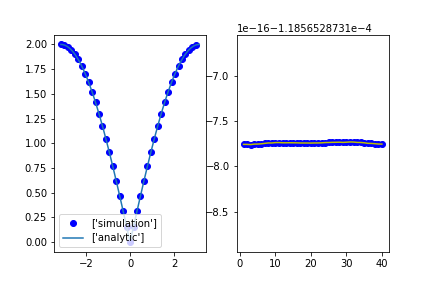

interactive(children=(IntSlider(value=10, description='N', max=50, min=2, step=2), FloatSlider(value=1.0, desc…

<function __main__.update(N=10, C=1, bc=0, M1=1, M2=1, imp_enabled=0, Nimp=3, Mimp=1, ModeNr=0)>

In [42]:
from matplotlib import pyplot as plt
%matplotlib notebook
# calling it a second time may prevent some graphics errors
%matplotlib notebook
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)


def update(N=10, C=1, bc=0, M1=1, M2=1, imp_enabled=0, Nimp=3, Mimp=1, ModeNr=0):
    # if M1!=M2 & N%2==1:
    #    N=N+1
    A = CreateForceMatrix(N)
    A = ForceMatrixBoundaryCond(A, bc, N)
    B = CreateMassMatrix(N, M1, M2, Nimp, Mimp, imp_enabled)
    omega, V, Nmodes = EigenEq(A, B, C, bc, N)
    Ka, Karg = FourierTransform(bc, V, N, Nmodes)
    V, omega, Ka = CorrectOmega(Ka, Karg, Nmodes, V, omega, bc, M1, M2, N)
    V = CorrectAmplitude(V, omega, C, N)
    # print(omega)
    # print(Ka)
    #fig, ax = plt.subplots();
    # ax.plot(Ka,omega,'bo',label=['simulation']);
    # fig
    PlotDisp(C, M1, M2, omega, Ka, ax1)
    PlotEigenmode(V, ModeNr-1, M1, M2, ax2, imp_enabled, Mimp, Nimp)

#     play = widgets.Play(
#     #     interval=10,
#         value=50,
#         min=0,
#         max=100,
#         step=1,
#         description="Press play",
#         disabled=False
#     )
#     print(play.value)
#     #plt.plot(np.sin(0.01*i*))
#     slider = widgets.IntSlider()
#     widgets.jslink((play, 'value'), (slider, 'value'))
#     widgets.HBox([play, slider])

    # fig
    # plt.plot(V[:,])
    # plt.plot(omega)
    # trace0 = Scatter(
    #    y=omega
    # )
    #data = [trace0]
    #iplot(data, filename = 'basic-line')
    # plt.plot(Ka)
    #scatter = f.data[0]
    #scatter.y = omega


#    print(bc)
interact(update, N=(2, 50, 2), M1=(0.1, 5, 0.1), M2=(0.1, 5, 0.1), Mimp=(0.1, 5, 0.1), ModeNr=(1, 5, 1), Nimp=(1, 10, 1), C=(
    0.2, 10, 0.2), imp_enabled=[('impurity disabled', 0), ('impurity enabled', 1)], bc=[('periodic', 0), ('fixed ends', 1), ('open ends', 2)])

<IPython.core.display.Javascript object>


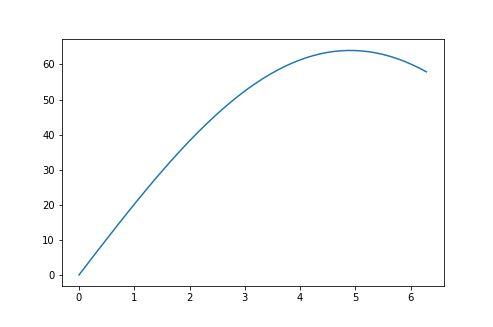

Link(source=(Play(value=1, description='Press play', interval=200), 'value'), target=(IntSlider(value=0), 'val…

In [53]:
# %matplotlib notebook
# def MakeAnim(change):
#     global x
#     global ax
#     w=change["new"]
#     print(w)
#     ax.cla()
#     ax.plot(x,w*np.sin(w * x*0.005))


# x = np.linspace(0, 2 * np.pi)
# fig,ax = plt.subplots(1, 1)
# ax.plot(x, np.sin(x))
# play = widgets.Play(
#     interval=200,
#     value=1,
#     min=0,
#     max=100,
#     step=1,
#     description="Press play",
#     disabled=False
# )
# slider = widgets.IntSlider(min=0,max=100, continuous_update=True)
# widgets.jslink((play, 'value'), (slider, 'value'))
# play.observe(MakeAnim, 'value')
# widgets.HBox([play, slider])

In [32]:
# print(widgets.Play.__doc__)

Play/repeat buttons to step through values automatically, and optionally loop.
    


In [33]:
# plt.plot(omega)
# trace0 = Scatter(
#     y=omega
# )
# data = [trace0]
# iplot(data, filename = 'basic-line')

In [34]:
# A=CreateForceMatrix(N)
# A = ForceMatrixBoundaryCond(A, bc, N)
# B = CreateMassMatrix(N, M1, M2, Nimp, Mimp)
# omega, V, Nmodes = EigenEq(A, B, C, bc, N)
# Ka, Karg = FourierTransform(bc,V, N, Nmodes)
# V,omega, Ka=CorrectOmega(Ka, Karg, Nmodes, V, omega, bc, M1, M2, N)
# A,V=CorrectAmplitude(V,omega,C,N)
# fig, ax = plt.subplots();
# ax.plot(Ka,omega,'bo',label=['simulation']);
# #fig
# #Analytic(C,M1,M2)
# #fig
# #plt.plot(V[:,])
# #plt.plot(omega)
# #plt.plot(Ka)
# print(bc)

In [35]:
# plt.plot(V[:,0])

In [63]:
#omega

In [64]:
#V